In [2]:
import pandas as pd
import glob
import os

# Load metadata from CSV
metadata = pd.read_csv('voice_annotations.csv')

# 定义一个函数，利用递归搜索找到对应的音频文件的完整路径
def find_audio_file(fn):
    # 构造搜索模式，递归搜索Voice文件夹中所有子文件夹
    search_pattern = os.path.join('./Voice', '**', fn)
    matching_files = glob.glob(search_pattern, recursive=True)
    if matching_files:
        # 返回第一个匹配项的绝对路径
        return os.path.abspath(matching_files[0])
    else:
        return None

# 如果 CSV 文件中包含 filename 列，则尝试构造完整路径
if 'filename' in metadata.columns:
    metadata['file_path'] = metadata['filename'].apply(lambda fn: find_audio_file(fn))
elif 'file_path' not in metadata.columns:
    # 如果没有文件路径，则递归搜索所有.wav文件
    audio_files = glob.glob('./Voice/**/*.wav', recursive=True)
    full_paths = [os.path.abspath(fp) for fp in audio_files]
    file_df = pd.DataFrame({'file_path': full_paths})
    # 假设 CSV 中有一个能够匹配文件名（例如ID或文件名）的字段，此处需要自行调整匹配规则
    # 例如，如果 CSV 中有 'filename' 列，就可以用下面的方式
    metadata = pd.merge(metadata, file_df, how='right', on='file_path')

# 检查加载的数据
print(f"Total audio files found: {len(metadata)}")
print(metadata.head())


Total audio files found: 1253
      filename          content folder  label  \
0    1-a_h.wav          a: high      1      0   
1    1-a_l.wav           a: low      1      0   
2  1-a_lhl.wav  a: low-high-low      1      0   
3    1-a_n.wav       a: natural      1      0   
4    1-i_h.wav          i: high      1      0   

                                           file_path  
0  /Users/beibeiliu/Downloads/4.20/Parkinson/Voic...  
1  /Users/beibeiliu/Downloads/4.20/Parkinson/Voic...  
2  /Users/beibeiliu/Downloads/4.20/Parkinson/Voic...  
3  /Users/beibeiliu/Downloads/4.20/Parkinson/Voic...  
4  /Users/beibeiliu/Downloads/4.20/Parkinson/Voic...  


In [3]:
from pydub import AudioSegment

max_duration_ms = 6000  # 6 seconds in milliseconds
chunks = []  # to collect chunk info

for _, row in metadata.iterrows():
    file_path = row['file_path']
    label = row['label']
    audio = AudioSegment.from_wav(file_path)
    duration_ms = len(audio)
    if duration_ms > max_duration_ms:
        # Split into consecutive chunks of <=6 seconds
        for i in range(0, duration_ms, max_duration_ms):
            chunk = audio[i:i+max_duration_ms]
            chunk_path = f"{os.path.splitext(file_path)[0]}_chunk{i//1000}.wav"
            chunk.export(chunk_path, format="wav")
            chunks.append({"file_path": chunk_path, "label": label})
    else:
        # No splitting needed, use the original file
        chunks.append({"file_path": file_path, "label": label})

# Create DataFrame for all chunks
chunks_df = pd.DataFrame(chunks)
print(f"Total chunks after splitting: {len(chunks_df)}")
print(chunks_df.head())


Total chunks after splitting: 2412
                                           file_path  label
0  /Users/beibeiliu/Downloads/4.20/Parkinson/Voic...      0
1  /Users/beibeiliu/Downloads/4.20/Parkinson/Voic...      0
2  /Users/beibeiliu/Downloads/4.20/Parkinson/Voic...      0
3  /Users/beibeiliu/Downloads/4.20/Parkinson/Voic...      0
4  /Users/beibeiliu/Downloads/4.20/Parkinson/Voic...      0


In [4]:
import numpy as np
import librosa
from sklearn.cluster import KMeans
import traceback
import pickle

# 参数设置
sr = 22050            # 采样率
n_mfcc = 20           # MFCC 系数数目
hop_length = 512      # 每帧步长
n_fft = 2048          # FFT 窗口大小
n_clusters = 64       # 码本大小

# 定义 MFCC 特征提取函数
def extract_mfcc(audio_path, sr=22050, n_mfcc=20, hop_length=512, n_fft=2048):
    try:
        audio, sr = librosa.load(audio_path, sr=sr)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None, None
    try:
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, 
                                    hop_length=hop_length, n_fft=n_fft)
    except Exception as e:
        print(f"Error extracting MFCC from {audio_path}: {e}")
        return None, audio
    return mfcc, audio

# 定义 KMeans 矢量量化函数，对MFCC特征进行离散化
def perform_vector_quantization(mfcc_features, n_clusters=64, random_state=42):
    # mfcc_features 的 shape 为 (n_mfcc, n_frames)，转置为 (n_frames, n_mfcc)
    features = mfcc_features.T
    num_frames = features.shape[0]
    if num_frames < n_clusters:
        print(f"Warning: only {num_frames} frames available, adjust n_clusters from {n_clusters} to {num_frames}")
        n_clusters = num_frames
    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        kmeans.fit(features)
        tokens = kmeans.predict(features)  # 每帧对应一个 token id
    except Exception as e:
        print("KMeans clustering error:")
        traceback.print_exc()
        return None, None
    return kmeans, tokens

# 对每个音频块进行处理，并保存token序列结果
token_results = []

for idx, row in chunks_df.iterrows():
    file_path = row['file_path']
    label = row['label']
    print(f"Processing: {file_path}, Label: {label}")
    mfcc_features, audio = extract_mfcc(file_path, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    if mfcc_features is None:
        print(f"Skipping {file_path} due to MFCC extraction error.")
        continue
    kmeans_model, tokens = perform_vector_quantization(mfcc_features, n_clusters=n_clusters)
    if tokens is None:
        print(f"Skipping {file_path} due to KMeans error.")
        continue
    # 可选：保存当前 kmeans 模型，确保最新模型只保留当前版本（如有需要，可删除旧模型）
    model_save_path = file_path.replace(".wav", f"_vq_kmeans_{n_clusters}.pkl")
    try:
        with open(model_save_path, "wb") as f:
            pickle.dump(kmeans_model, f)
        print(f"Saved KMeans model to {model_save_path}")
    except Exception as e:
        print(f"Error saving model for {file_path}: {e}")
    token_results.append({
        "file_path": file_path,
        "label": label,
        "tokens": tokens.tolist()
    })

# 转换成 DataFrame 方便后续分析
token_df = pd.DataFrame(token_results)
print("Tokenization complete. Sample output:")
print(token_df.head())

# 将结果保存到 CSV 文件中（可选）
token_df.to_csv("audio_token_results.csv", index=False, encoding="utf-8-sig")
print("Token results saved to audio_token_results.csv")


Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1/1-a_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1/1-a_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1/1-a_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1/1-a_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1/1-a_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1/1-a_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1/1-a_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1/1-a_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1/1-i_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/102/102-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/102/102-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/102/102-u_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/102/102-u_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/102/102-u_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/104/104-a_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/104/104-a_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/104/104-a_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/104/104-a_l_vq_kmeans_64.pkl
Proc

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/113/113-a_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/113/113-a_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/113/113-a_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/113/113-i_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/113/113-i_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/113/113-i_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/113/113-i_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/113/113-i_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/113/113-i_lhl_vq_kmeans_64.pkl
Pr

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/115/115-phrase_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/115/115-u_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/115/115-u_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/115/115-u_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/115/115-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/115/115-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/115/115-u_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/115/115-u_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/115/115-u_n_vq_kmeans_64.pkl
P

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/12/12-i_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/12/12-i_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/12/12-i_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/12/12-i_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/12/12-i_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/12/12-i_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/12/12-i_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/12/12-phrase.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/12/12-phrase_vq_kmeans_64.pkl
Processing: /Use

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/122/122-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/122/122-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/122/122-u_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/122/122-u_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/122/122-u_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/123/123-a_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/123/123-a_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/123/123-a_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/123/123-a_l_vq_kmeans_64.pkl
Proc

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/125/125-i_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/125/125-i_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/125/125-i_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/125/125-i_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/125/125-i_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/125/125-i_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/125/125-i_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/125/125-phrase.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/125/125-phrase_vq_kmeans_64.pk

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/13/13-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/13/13-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/13/13-u_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/13/13-u_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/13/13-u_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/133/133-a_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/133/133-a_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/133/133-a_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/133/133-a_l_vq_kmeans_64.pkl
Processing: /U

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1359/1359-i_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1359/1359-i_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1359/1359-i_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1359/1359-i_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1359/1359-i_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1359/1359-phrase.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1359/1359-phrase_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1359/1359-u_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/1359/1359-u

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/14/14-a_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/14/14-a_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/14/14-a_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/14/14-a_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/14/14-a_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/14/14-i_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/14/14-i_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/14/14-i_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/14/14-i_l_vq_kmeans_64.pkl
Processing: /Users/bei

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/153/153-i_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/153/153-phrase.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/153/153-phrase_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/153/153-u_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/153/153-u_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/153/153-u_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/153/153-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/153/153-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/153/153-u_lhl_vq_kmeans_64.pk

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/158/158-u_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/158/158-u_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/158/158-u_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_PD/1580-a_h.wav, Label: 1
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_PD/1580-a_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_PD/1580-a_l.wav, Label: 1
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_PD/1580-a_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_PD/1580-a_lhl.wav, Label: 1
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_PD/1580-a_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/Ge

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/17/17-i_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/17/17-i_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/17/17-i_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/17/17-i_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/17/17-i_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/17/17-i_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/17/17-i_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/17/17-phrase.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/17/17-phrase_vq_kmeans_64.pkl
Processing: /Use

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/19/19-u_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/2/2-a_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/2/2-a_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/2/2-a_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/2/2-a_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/2/2-a_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/2/2-a_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/2/2-a_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/2/2-a_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/21/21-phrase_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/21/21-u_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/21/21-u_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/21/21-u_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/21/21-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/21/21-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/21/21-u_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/21/21-u_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/21/21-u_n_vq_kmeans_64.pkl
Processing: /Users/

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/25/25-a_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/25/25-a_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/25/25-a_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/25/25-i_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/25/25-i_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/25/25-i_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/25/25-i_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/25/25-i_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/25/25-i_lhl_vq_kmeans_64.pkl
Processing: /Users/b

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/27/27-i_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/27/27-phrase.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/27/27-phrase_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/27/27-u_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/27/27-u_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/27/27-u_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/27/27-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/27/27-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/27/27-u_lhl_vq_kmeans_64.pkl
Processing: /Use

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/3/3-u_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/30/30-a_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/30/30-a_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/30/30-a_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/30/30-a_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/30/30-a_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/30/30-a_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/30/30-a_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/30/30-a_n_vq_kmeans_64.pkl
Processing: /Users/beibe

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/33/33-a_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/33/33-i_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/33/33-i_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/33/33-i_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/33/33-i_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/33/33-i_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/33/33-i_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/33/33-i_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/33/33-i_n_vq_kmeans_64.pkl
Processing: /Users/bei

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/35/35-u_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/35/35-u_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/35/35-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/35/35-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/35/35-u_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/35/35-u_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/35/35-u_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/36/36-a_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/36/36-a_h_vq_kmeans_64.pkl
Processing: /Users/bei

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/38/38-i_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/38/38-i_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/38/38-i_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/38/38-phrase.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/38/38-phrase_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/38/38-u_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/38/38-u_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/38/38-u_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/38/38-u_l_vq_kmeans_64.pkl
Processing: /Users

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/42/42-u_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/44/44-a_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/44/44-a_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/44/44-a_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/44/44-a_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/44/44-a_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/44/44-a_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/44/44-a_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/44/44-a_n_vq_kmeans_64.pkl
Processing: /Users/bei

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/46/46-u_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/46/46-u_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/46/46-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/46/46-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/46/46-u_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/46/46-u_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/46/46-u_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/47/47-a_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/47/47-a_h_vq_kmeans_64.pkl
Processing: /Users/bei

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/49/49-i_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/49/49-phrase.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/49/49-phrase_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/49/49-u_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/49/49-u_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/49/49-u_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/49/49-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/49/49-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/49/49-u_lhl_vq_kmeans_64.pkl
Processing: /Use

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/54/54-a_lhl_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/54/54-a_n.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/54/54-a_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/54/54-i_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/54/54-i_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/54/54-i_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/54/54-i_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/54/54-i_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/54/54-i_lhl_vq_kmeans_64.pkl
Processing: /Users/b

Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/56/56-i_n_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/56/56-phrase.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/56/56-phrase_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/56/56-u_h.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/56/56-u_h_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/56/56-u_l.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/56/56-u_l_vq_kmeans_64.pkl
Processing: /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/56/56-u_lhl.wav, Label: 0
Saved KMeans model to /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_HC/Female/56/56-u_lhl_vq_kmeans_64.pkl
Processing: /Use

/var/folders/dh/864dwk3j1k71y3_gzl0zgk5c0000gn/T/ipykernel_74705/887414455.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=sr)
/Users/beibeiliu/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Top tokens with highest divergence (token, divergence, HC frequency, PD frequency):
Token 3: divergence = 0.0027, HC = 0.0193, PD = 0.0221
Token 60: divergence = 0.0023, HC = 0.0104, PD = 0.0127
Token 58: divergence = 0.0019, HC = 0.0109, PD = 0.0128
Token 51: divergence = 0.0019, HC = 0.0121, PD = 0.0140
Token 13: divergence = 0.0015, HC = 0.0191, PD = 0.0176


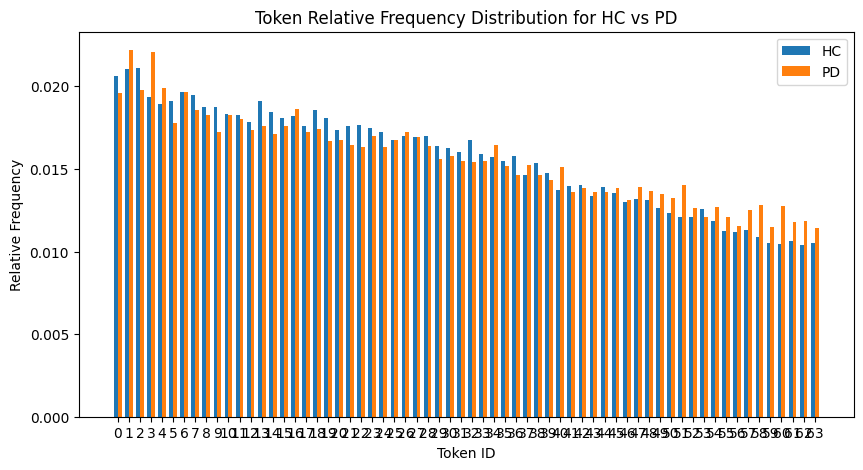

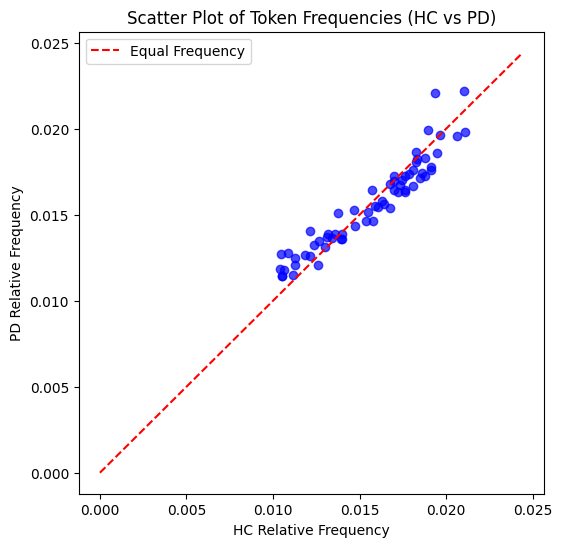

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 假设 token_df 已包含每个音频块的 token 序列及 label（0: HC, 1: PD）
# 注意：这里 token_df 中 "tokens" 列为 list 格式；若为字符串，请先转换为 list

# 分离 HC 和 PD 的 token 序列
hc_tokens = []
pd_tokens = []
for _, row in token_df.iterrows():
    tokens = row['tokens']
    # label 为 0 表示 HC，1 表示 PD；支持字符串或数字格式
    if str(row['label']) == '0' or row['label'] == 0:
        hc_tokens.extend(tokens)
    elif str(row['label']) == '1' or row['label'] == 1:
        pd_tokens.extend(tokens)

# 统计每个 token 在两组中的出现次数
hc_counter = Counter(hc_tokens)
pd_counter = Counter(pd_tokens)

# 码本大小与 n_clusters 保持一致
all_tokens = list(range(n_clusters))

# 计算相对频率
total_hc = sum(hc_counter.values())
total_pd = sum(pd_counter.values())
hc_freq = {t: hc_counter[t] / total_hc for t in all_tokens}
pd_freq = {t: pd_counter[t] / total_pd for t in all_tokens}

# 计算每个 token 的绝对频率差（作为简单的分歧度指标）
divergence = {t: abs(hc_freq[t] - pd_freq[t]) for t in all_tokens}

# 按分歧度降序排列，取 top 5（可以根据需求调整）
sorted_tokens = sorted(divergence.items(), key=lambda x: x[1], reverse=True)
top_n = 5
top_tokens = sorted_tokens[:top_n]

print("Top tokens with highest divergence (token, divergence, HC frequency, PD frequency):")
for t, diff in top_tokens:
    print(f"Token {t}: divergence = {diff:.4f}, HC = {hc_freq[t]:.4f}, PD = {pd_freq[t]:.4f}")

# --- 可视化：条形图 ---
plt.figure(figsize=(10, 5))
x = np.array(all_tokens)
hc_values = np.array([hc_freq[t] for t in all_tokens])
pd_values = np.array([pd_freq[t] for t in all_tokens])
width = 0.35
plt.bar(x - width/2, hc_values, width, label='HC')
plt.bar(x + width/2, pd_values, width, label='PD')
plt.xlabel('Token ID')
plt.ylabel('Relative Frequency')
plt.title('Token Relative Frequency Distribution for HC vs PD')
plt.xticks(x)
plt.legend()
plt.show()

# --- 可视化：散点图 ---
plt.figure(figsize=(6, 6))
plt.scatter(hc_values, pd_values, color='blue', alpha=0.7)
max_val = max(hc_values.max(), pd_values.max()) * 1.1
plt.plot([0, max_val], [0, max_val], 'r--', label='Equal Frequency')
plt.xlabel('HC Relative Frequency')
plt.ylabel('PD Relative Frequency')
plt.title('Scatter Plot of Token Frequencies (HC vs PD)')
plt.legend(loc='upper left')
plt.show()


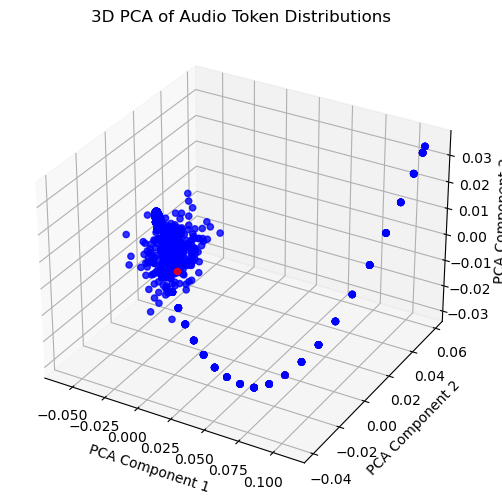

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# 定义一个辅助函数：计算 token 分布向量
def compute_token_distribution(token_list, n_clusters):
    counts = np.bincount(token_list, minlength=n_clusters)
    total = counts.sum()
    return counts / total if total > 0 else counts

# 从 token_df 中计算每个音频块的 token 分布向量
features_list = []
labels_list = []
for idx, row in token_df.iterrows():
    tokens = row['tokens']  # 已经为 list 格式
    dist = compute_token_distribution(tokens, n_clusters)
    features_list.append(dist)
    labels_list.append(row['label'])

features_array = np.vstack(features_list)

# 用 PCA 将原始 64 维 token 分布降至 3 维
pca_3d = PCA(n_components=3)
features_3d = pca_3d.fit_transform(features_array)

# 绘制 3D 散点图
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# 根据标签选择颜色：label 0 -> blue, label 1 -> red
colors = ['blue' if (str(l)=='0' or l==0) else 'red' for l in labels_list]

ax.scatter(features_3d[:,0], features_3d[:,1], features_3d[:,2], 
           c=colors, alpha=0.8)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("3D PCA of Audio Token Distributions")
plt.show()


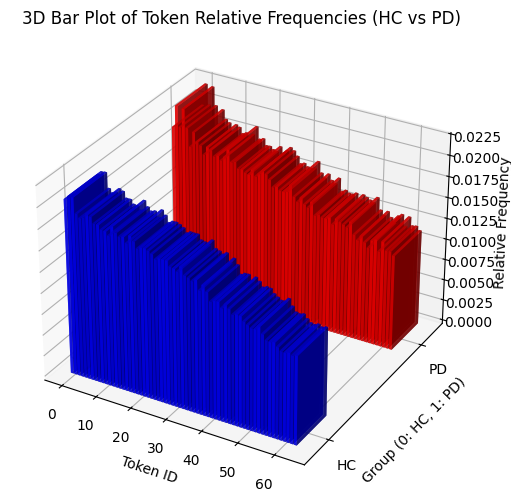

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

# 分离 HC 和 PD 的 token 序列
hc_tokens = []
pd_tokens = []
for idx, row in token_df.iterrows():
    tokens = row['tokens']
    if str(row['label']) in ['0', '0.0']:
        hc_tokens.extend(tokens)
    elif str(row['label']) in ['1', '1.0']:
        pd_tokens.extend(tokens)

# 使用 Counter 统计 token 出现次数
hc_counter = Counter(hc_tokens)
pd_counter = Counter(pd_tokens)
all_tokens = list(range(n_clusters))
total_hc = sum(hc_counter.values())
total_pd = sum(pd_counter.values())

# 计算每个 token 的相对频率
hc_freq = np.array([hc_counter[t] / total_hc for t in all_tokens])
pd_freq = np.array([pd_counter[t] / total_pd for t in all_tokens])

# 绘制 3D 条形图：X 为 token ID, Y 为组别（0: HC, 1: PD）, Z 为相对频率
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(n_clusters)  # token ID
# 设定两组的 Y 坐标：HC 在 y=0, PD 在 y=1
y_hc = np.zeros(n_clusters)
y_pd = np.ones(n_clusters)
dx = 0.8  # X 方向的宽度
dy = 0.3  # Y 方向的宽度

# 绘制 HC 组的条形
ax.bar3d(x - dx/2, y_hc - dy/2, np.zeros(n_clusters), dx, dy, hc_freq, 
         color='blue', alpha=0.7, label='HC')

# 绘制 PD 组的条形
ax.bar3d(x - dx/2, y_pd - dy/2, np.zeros(n_clusters), dx, dy, pd_freq, 
         color='red', alpha=0.7, label='PD')

ax.set_xlabel('Token ID')
ax.set_ylabel('Group (0: HC, 1: PD)')
ax.set_zlabel('Relative Frequency')
ax.set_title('3D Bar Plot of Token Relative Frequencies (HC vs PD)')
# 对 Y 轴做标记
ax.set_yticks([0, 1])
ax.set_yticklabels(['HC', 'PD'])
plt.show()


In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import librosa
import torch
import numpy as np
import pandas as pd

# 加载本地 Qwen2.5-7B-Instruct 模型和 tokenizer
model_name = "./Qwen2.5-7B-Instruct"
tokenizer_llm = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model_llm = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=True)

def get_acoustic_description(audio_path):
    """
    Read the audio chunk at audio_path, compute basic acoustic features (duration, average RMS, ZCR),
    then construct an English prompt and call the Qwen2.5-7B-Instruct model to generate a description of the acoustic properties.
    """
    y, sr = librosa.load(audio_path, sr=None)
    duration = len(y) / sr
    rms = float(np.mean(librosa.feature.rms(y=y)))
    zcr = float(np.mean(librosa.feature.zero_crossing_rate(y=y)))
    
    prompt = (
        f"Audio Duration: {duration:.2f} seconds.\n"
        f"Average RMS (loudness): {rms:.4f}.\n"
        f"Average Zero-Crossing Rate: {zcr:.4f}.\n\n"
        "Based on these acoustic features, provide a detailed description of the voice quality. "
        "Focus on aspects such as pitch (high/low, steady/varied), tone (clear, breathy, shaky), "
        "rhythm (smooth or irregular), and any noticeable tremor. Do not include any semantic content—only describe the acoustic properties."
    )
    
    input_ids = tokenizer_llm(prompt, return_tensors="pt").input_ids.to(model_llm.device)
    # Generate the acoustic description
    output_ids = model_llm.generate(input_ids, max_length=150, do_sample=True, top_p=0.9, temperature=0.7)
    description = tokenizer_llm.decode(output_ids[0], skip_special_tokens=True)
    return description.strip()

# 假设你在 Cell 4 中计算出 top_tokens 列表，格式为 list of tuples: (token, divergence, HC_frequency, PD_frequency)
# 此外 token_df 为之前生成的包含每个音频块 token 序列的 DataFrame

# 举例：如果 top_tokens 尚未定义，请使用下面的示例
# top_tokens = [(3, 0.05), (10, 0.048), (25, 0.044), (7, 0.040), (12, 0.038)]
# 此处我们假设 top_tokens 是从 Cell 4 得到的

# 以下代码将遍历 top_tokens 并为每个 token 选择代表性音频块，并调用 LLM 生成描述
top_token_info = []
for token_tuple in top_tokens:
    token, diff = token_tuple  # token id and divergence
    # Determine target group: if PD frequency is higher, select PD; otherwise, select HC.
    target_group = 'PD' if pd_freq[token] > hc_freq[token] else 'HC'
    # 从 token_df 中挑选包含该 token 且 label 为 target_group 的记录
    candidates = token_df[(token_df['label'].astype(str) == ('1' if target_group == 'PD' else '0')) & 
                          (token_df['tokens'].apply(lambda ts: token in ts))]
    if candidates.empty:
        print(f"No candidate found for token {token} in group {target_group}.")
        continue
    candidate_row = candidates.iloc[0]
    audio_path = candidate_row['file_path']
    llm_desc = get_acoustic_description(audio_path)
    top_token_info.append({
        "token": token,
        "target_group": target_group,
        "audio_path": audio_path,
        "llm_description": llm_desc,
        "divergence": diff,
        "HC_freq": hc_freq[token],
        "PD_freq": pd_freq[token]
    })
    print(f"Token {token} ({target_group}) description:\n{llm_desc}\n")

# 保存结果到 CSV 文件
top_token_df = pd.DataFrame(top_token_info)
top_token_df.to_csv("top_token_acoustic_descriptions.csv", index=False, encoding="utf-8-sig")
print("Acoustic descriptions saved to top_token_acoustic_descriptions.csv")


2025-04-09 23:24:31.089084: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 23:24:31.128312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 23:24:31.951586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Token 3 (PD) description:
Audio Duration: 0.58 seconds.
Average RMS (loudness): 0.2313.
Average Zero-Crossing Rate: 0.0170.

Based on these acoustic features, provide a detailed description of the voice quality. Focus on aspects such as pitch (high/low, steady/varied), tone (clear, breathy, shaky), rhythm (smooth or irregular), and any noticeable tremor. Do not include any semantic content—only describe the acoustic properties. The audio has a duration of 0.58 seconds with an average RMS value of 0.2313, indicating a moderate loudness level. The zero-crossing rate is 0.0170,

Token 60 (PD) description:
Audio Duration: 2.31 seconds.
Average RMS (loudness): 0.1862.
Average Zero-Crossing Rate: 0.0232.

Based on these acoustic features, provide a detailed description of the voice quality. Focus on aspects such as pitch (high/low, steady/varied), tone (clear, breathy, shaky), rhythm (smooth or irregular), and any noticeable tremor. Do not include any semantic content—only describe the acous

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import librosa

# Load the Qwen2.5-7B-Instruct model and tokenizer (ensure you have the model locally or use from_pretrained)
model_name = "/Qwen2.5-7B-Instruct"
tokenizer_qwen = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model_qwen = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=True)

def describe_audio_chunk(file_path):
    """Generate an acoustic description for the audio chunk at file_path."""
    y, sr = librosa.load(file_path, sr=None)
    duration = len(y) / sr
    # Compute basic acoustic features for context
    rms = float(np.mean(librosa.feature.rms(y=y)))
    zcr = float(np.mean(librosa.feature.zero_crossing_rate(y=y)))
    # Estimate pitch (fundamental frequency) using librosa.yin
    f0 = librosa.yin(y, fmin=50, fmax=500, sr=sr)
    f0_valid = f0[f0 > 0]  # filter unvoiced parts
    if len(f0_valid) > 0:
        pitch_mean = float(np.mean(f0_valid))
        pitch_min = float(np.min(f0_valid))
        pitch_max = float(np.max(f0_valid))
        pitch_range = pitch_max - pitch_min
    else:
        pitch_mean = pitch_min = pitch_max = pitch_range = 0.0

    # Formulate the prompt for the LLM focusing on acoustic features
    prompt = (
        f"Audio duration: {duration:.2f} seconds.\n"
        f"Mean pitch: {pitch_mean:.1f} Hz (range {pitch_range:.1f} Hz).\n"
        f"Average loudness (RMS): {rms:.4f}.\n"
        f"Zero-crossing rate: {zcr:.4f}.\n\n"
        "Based on these acoustic characteristics, describe how the voice in this audio segment sounds. "
        "Focus on qualities like pitch (high/low, steady/varied), tone (clear, breathy, shaky), volume (loud/soft), and any noticeable tremor or monotony. "
        "Do not mention any words or semantic content, only describe the sound of the voice."
    )
    # Generate the description using Qwen model
    input_ids = tokenizer_qwen(prompt, return_tensors='pt').input_ids.to(model_qwen.device)
    output_ids = model_qwen.generate(input_ids, max_length=150, do_sample=True, top_p=0.9, temperature=0.7)
    description = tokenizer_qwen.decode(output_ids[0], skip_special_tokens=True)
    return description.strip()

# Select representative chunks for top tokens and get LLM descriptions
representative_info = []
for token, p_hc, p_pd, diff in top_divergent_tokens:
    # Choose target class where this token is more common
    target_class = 'PD' if p_pd > p_hc else 'HC'
    # Find a chunk from the target class containing this token
    chunk_row = token_df[(token_df.label == target_class) & (token_df.tokens.apply(lambda seq: token in seq))].iloc[0]
    chunk_path = chunk_row.file_path
    # Generate acoustic description for this audio chunk
    description = describe_audio_chunk(chunk_path)
    representative_info.append({
        "token": token,
        "class": target_class,
        "audio_path": chunk_path,
        "token_sequence": " ".join(map(str, chunk_row.tokens.tolist())),
        "p_HC": p_hc,
        "p_PD": p_pd,
        "divergence": diff,
        "acoustic_description": description
    })
    print(f"Token {token} ({target_class}) description:\n{description}\n")


/tmp/ipykernel_3961/3489266159.py:122: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3961/3489266159.py:122: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3961/3489266159.py:122: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3961/3489266159.py:122: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3961/3489266159.py:122: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3961/3489266159.py:122: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3961/3489266159.py:122: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) mi

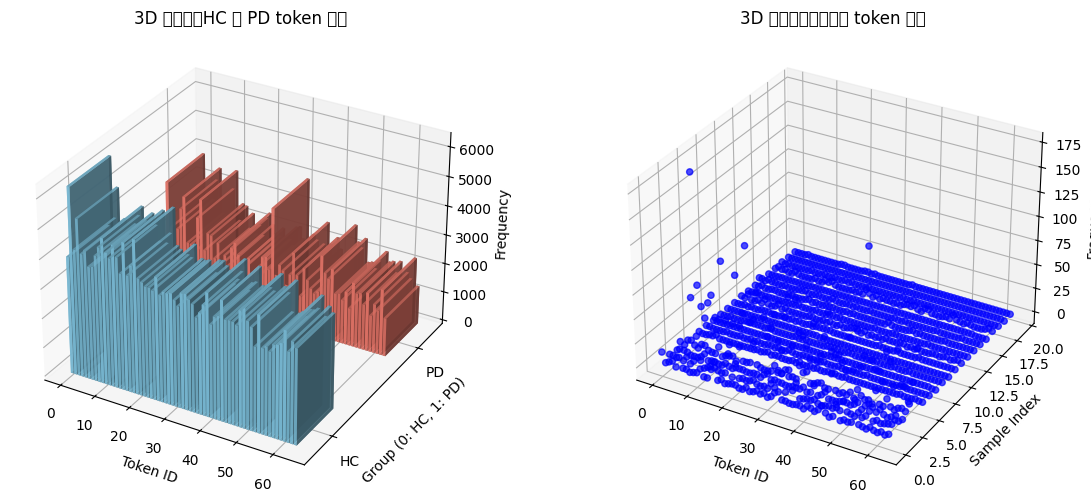

In [8]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 参数设置（根据之前 KMeans 中设定的 n_clusters，即码本大小）
n_clusters = 64

# -----------------------------------------------------
# 1. 加载CSV数据，并解析 token 序列
# -----------------------------------------------------
csv_file = 'audio_vq_results.csv'
try:
    df = pd.read_csv(csv_file, encoding="utf-8-sig")
except Exception as e:
    print(f"读取 CSV 文件出错: {e}")
    exit(1)

# 解析 tokens 字段，将字符串转换为列表
def parse_tokens(token_str):
    try:
        tokens = ast.literal_eval(token_str)
        return tokens
    except Exception as e:
        print(f"解析 tokens 时出错: {e}")
        return []

df['tokens_parsed'] = df['tokens'].apply(parse_tokens)

# -----------------------------------------------------
# 2. 按照标签分组，统计 token 分布
# -----------------------------------------------------

# 初始化两个频率数组，分别用于 HC 和 PD，长度为 n_clusters，初值为0
counts_HC = np.zeros(n_clusters, dtype=int)
counts_PD = np.zeros(n_clusters, dtype=int)

# 遍历每一行数据，累加 token 出现次数
for idx, row in df.iterrows():
    tokens = row['tokens_parsed']
    label = row['label']
    # 统计当前样本中各 token 的频数
    token_counts = np.bincount(tokens, minlength=n_clusters)
    if label.upper() == "HC":
        counts_HC += token_counts
    elif label.upper() == "PD":
        counts_PD += token_counts
    else:
        # 如果标签不为 HC 或 PD，可按需要忽略或额外处理
        pass

# 为了直观比较，也可以计算比例（归一化）
total_HC = counts_HC.sum()
total_PD = counts_PD.sum()
dist_HC = counts_HC / total_HC if total_HC > 0 else counts_HC
dist_PD = counts_PD / total_PD if total_PD > 0 else counts_PD

# -----------------------------------------------------
# 3. 使用 3D 条形图展示两组 token 分布
# -----------------------------------------------------
fig = plt.figure(figsize=(14, 6))

# 3D条形图：将HC和PD的token分布放在同一张图上，使用 y 轴区分两个组
ax = fig.add_subplot(121, projection='3d')
x = np.arange(n_clusters)  # token id 坐标
dx = 0.8  # 每个条形的宽度

# 分别为 HC 和 PD 设置不同 y 位置
y_HC = np.zeros(n_clusters)  # HC 在 y=0 位置
y_PD = np.ones(n_clusters)   # PD 在 y=1 位置
dy = 0.4  # 条形在 y 方向的宽度

# z 值为频数，绘制条形
ax.bar3d(x, y_HC, np.zeros(n_clusters), dx, dy, counts_HC, color='skyblue', alpha=0.8, label='HC')
ax.bar3d(x, y_PD, np.zeros(n_clusters), dx, dy, counts_PD, color='salmon', alpha=0.8, label='PD')

ax.set_xlabel('Token ID')
ax.set_ylabel('Group (0: HC, 1: PD)')
ax.set_zlabel('Frequency')
ax.set_title('3D 条形图：HC 与 PD token 分布')
ax.set_yticks([0.2, 1.2])
ax.set_yticklabels(['HC', 'PD'])

# -----------------------------------------------------
# 4. 使用 3D 散点图展示分布特征（加入 token ID, 出现频率及不同样本间的散点分布）
# -----------------------------------------------------
# 此处我们将所有样本的 token 分布“堆叠”展示，从而观察各个文件中 token 分布的离散情况

ax2 = fig.add_subplot(122, projection='3d')

# 遍历数据，取部分样本进行展示（例如取前20个样本避免图中点过多）
max_samples = 20  
sample_count = 0

for idx, row in df.iterrows():
    tokens = row['tokens_parsed']
    label = row['label'].upper()
    if sample_count >= max_samples:
        break
    # 统计当前样本的 token 频数
    token_counts = np.bincount(tokens, minlength=n_clusters)
    # 对于每个 token, 绘制一个散点, x=token id, y=当前样本的序号, z=出现次数
    xs = np.arange(n_clusters)
    ys = np.full(n_clusters, sample_count)  # 每个样本的 y 坐标不同
    zs = token_counts
    if label == "HC":
        color = 'blue'
    elif label == "PD":
        color = 'red'
    else:
        color = 'gray'
    ax2.scatter(xs, ys, zs, c=color, marker='o', alpha=0.7)
    sample_count += 1

ax2.set_xlabel('Token ID')
ax2.set_ylabel('Sample Index')
ax2.set_zlabel('Frequency')
ax2.set_title('3D 散点图：单个样本 token 分布')
# 为 y 轴添加样本标签（可选，简单标记样本来源）
# 例如，将前几个样本的标签也标出来
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas

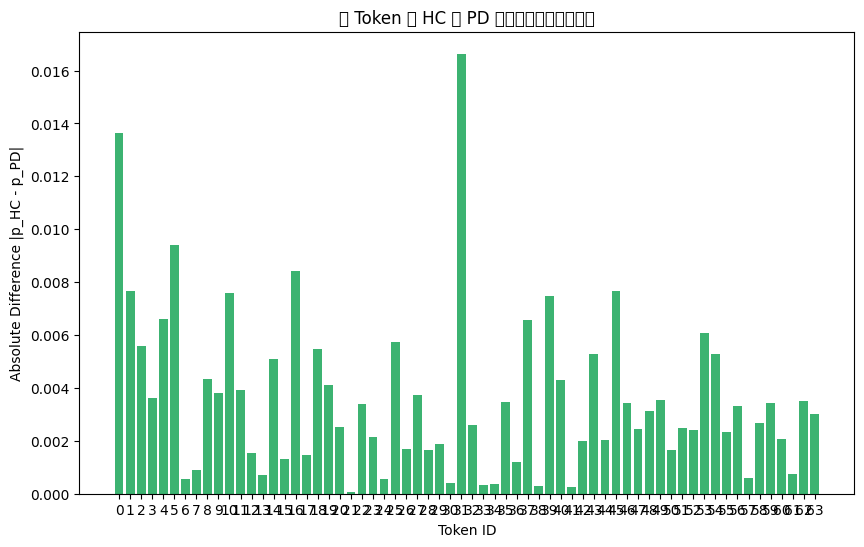

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20110 (\N{CJK UNIFIED IDEOGRAPH-4E8E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas

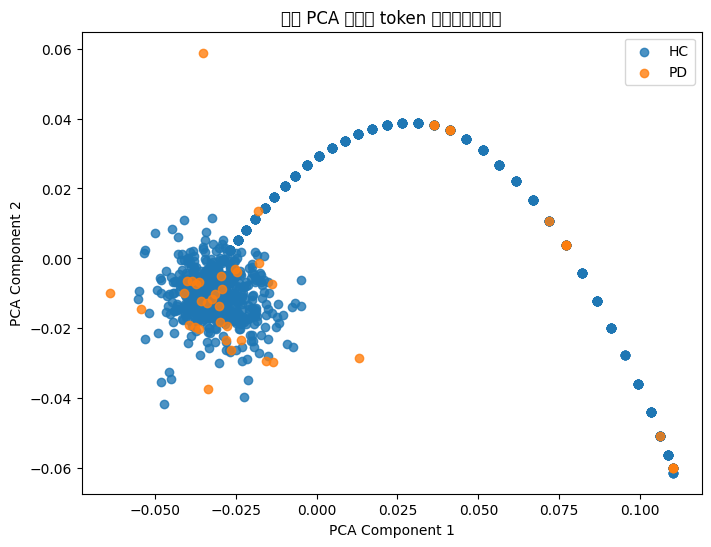

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20110 (\N{CJK UNIFIED IDEOGRAPH-4E8E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas

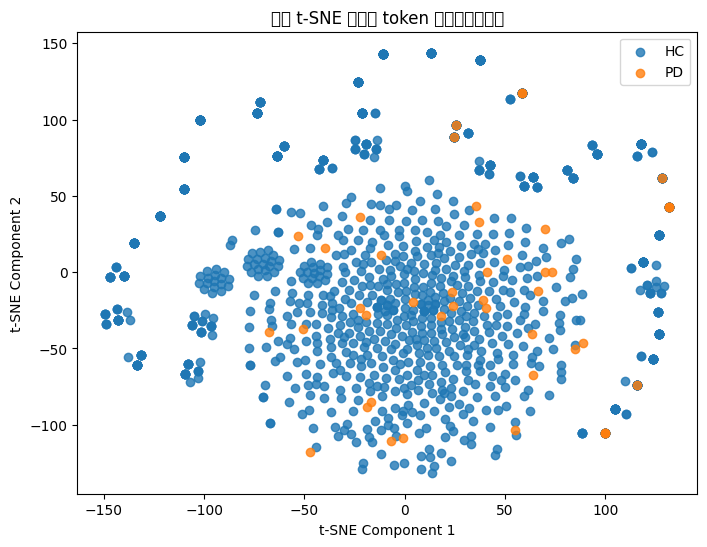

In [9]:
import os
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ---------------------------
# 1. 加载 CSV 数据，并解析 token 序列
# ---------------------------
csv_file = 'audio_vq_results.csv'
try:
    df = pd.read_csv(csv_file, encoding="utf-8-sig")
except Exception as e:
    print(f"读取 CSV 文件出错: {e}")
    exit(1)

# 将 tokens 列（字符串）转换为 Python 列表
def parse_tokens(token_str):
    try:
        tokens = ast.literal_eval(token_str)
        return tokens
    except Exception as e:
        print(f"解析 tokens 时出错: {e}")
        return []
        
df['tokens_parsed'] = df['tokens'].apply(parse_tokens)

# ---------------------------
# 2. 全局统计 & 每个 token 差异分析
# ---------------------------
n_clusters = 64  # 如果单个样本帧数不足，可以采用全局聚类后固定码本

# 初始化频数计数器（每组各 token 出现的次数）
counts_HC = np.zeros(n_clusters, dtype=int)
counts_PD = np.zeros(n_clusters, dtype=int)

# 同时记录每个样本的 token 分布（归一化后的频率向量），便于后续降维分析
sample_features = []  # 每行为一个样本的 token 向量
sample_labels = []    # 对应样本标签

for idx, row in df.iterrows():
    tokens = row['tokens_parsed']
    label = row['label'].upper()  # 转大写以统一比较
    # 统计当前样本中各 token 的次数
    token_counts = np.bincount(tokens, minlength=n_clusters)
    
    # 累加到全局组中
    if label == "HC":
        counts_HC += token_counts
    elif label == "PD":
        counts_PD += token_counts
    
    # 存储每个样本的 token 分布（归一化）
    total = token_counts.sum()
    if total > 0:
        sample_features.append(token_counts / total)
    else:
        sample_features.append(token_counts)
    sample_labels.append(label)

# 计算 HC、PD 组的全局归一化 token 分布
total_HC = counts_HC.sum()
total_PD = counts_PD.sum()
if total_HC > 0:
    dist_HC = counts_HC / total_HC
else:
    dist_HC = counts_HC
if total_PD > 0:
    dist_PD = counts_PD / total_PD
else:
    dist_PD = counts_PD

# 计算每个 token 的绝对频率差（|p_HC - p_PD|）
abs_diff = np.abs(dist_HC - dist_PD)
sorted_idx = np.argsort(abs_diff)[::-1]  # 按降序排序

# 绘制各 token 差异的柱状图
plt.figure(figsize=(10, 6))
plt.bar(np.arange(n_clusters), abs_diff, color='mediumseagreen')
plt.xlabel("Token ID")
plt.ylabel("Absolute Difference |p_HC - p_PD|")
plt.title("各 Token 在 HC 与 PD 组中的归一化频率差异")
plt.xticks(np.arange(n_clusters))
plt.show()

# ---------------------------
# 3. 基于样本分布的降维可视化
# ---------------------------
sample_features = np.array(sample_features)  # shape: (n_samples, n_clusters)

# （1）PCA 降维到 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_features)

plt.figure(figsize=(8, 6))
for label in ['HC', 'PD']:
    idxs = [i for i, l in enumerate(sample_labels) if l == label]
    plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1],
                label=label, alpha=0.8)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("基于 PCA 的样本 token 分布降维可视化")
plt.legend()
plt.show()

# （2）t-SNE 降维到 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(sample_features)

plt.figure(figsize=(8, 6))
for label in ['HC', 'PD']:
    idxs = [i for i, l in enumerate(sample_labels) if l == label]
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1],
                label=label, alpha=0.8)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("基于 t-SNE 的样本 token 分布降维可视化")
plt.legend()
plt.show()


合并后记录数: 1255
合并后的字段: ['file_path', 'label_x', 'tokens', 'tokens_parsed', 'audio_feature', 'basename', 'content', 'folder', 'label_y', 'label_str']
多模态特征维度: (1255, 364)
随机森林分类报告:
              precision    recall  f1-score   support

          HC       0.96      1.00      0.98       242
          PD       0.00      0.00      0.00         9

    accuracy                           0.96       251
   macro avg       0.48      0.50      0.49       251
weighted avg       0.93      0.96      0.94       251

5折交叉验证平均准确率: 0.9355
KMeans 聚类的 silhouette_score: 0.2738
KMeans 聚类结果分布:
  Cluster 0: 444 个样本
  Cluster 1: 811 个样本


/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  fig.canvas

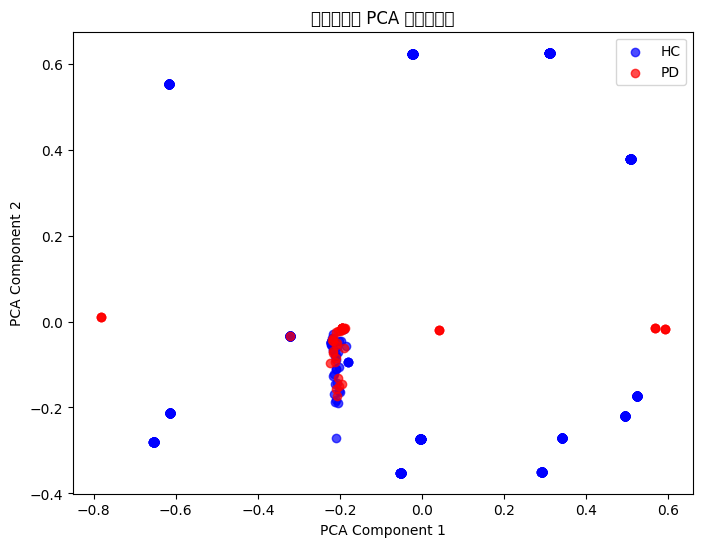

In [11]:
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import classification_report, silhouette_score

# ===========================
# 1. 加载语音矢量量化结果数据
# ===========================
audio_vq_file = "audio_vq_results.csv"
try:
    df_audio = pd.read_csv(audio_vq_file, encoding="utf-8-sig")
except Exception as e:
    print(f"加载 {audio_vq_file} 出错: {e}")
    raise

# 解析 tokens 字符串为 Python 列表
def parse_tokens(token_str):
    try:
        return ast.literal_eval(token_str)
    except Exception as e:
        print(f"解析 tokens 时出错: {e}")
        return []

df_audio['tokens_parsed'] = df_audio['tokens'].apply(parse_tokens)

# 这里 n_clusters 需与 KMeans 时设置一致
n_clusters = 64
def compute_token_distribution(token_list, n_clusters):
    """
    将单个音频的 token 序列统计成固定长度的频率向量
    """
    counts = np.bincount(token_list, minlength=n_clusters)
    total = counts.sum()
    if total > 0:
        return counts / total
    else:
        return np.zeros(n_clusters)

df_audio['audio_feature'] = df_audio['tokens_parsed'].apply(
    lambda t: compute_token_distribution(t, n_clusters)
)

# 为后续合并方便，提取文件名（basename）作为键
df_audio['basename'] = df_audio['file_path'].apply(lambda x: os.path.basename(x))


# ===========================
# 2. 加载描述性元数据（voice_annotations.csv）
# ===========================
meta_file = "voice_annotations.csv"
try:
    df_meta = pd.read_csv(meta_file, encoding="utf-8-sig")
except Exception as e:
    print(f"加载 {meta_file} 出错: {e}")
    raise

# 假定 df_meta 包含：filename, content, folder, label
# 此处将 label 数值转换为字符串表示（0->HC，1->PD）
def convert_label(label):
    try:
        label = int(label)
    except:
        return "Unknown"
    return "HC" if label == 0 else "PD"

df_meta['label_str'] = df_meta['label'].apply(convert_label)

# 为后续合并，保证文件名字段统一：重命名 filename 为 basename
df_meta.rename(columns={'filename': 'basename'}, inplace=True)


# ===========================
# 3. 多模态数据对齐：以 basename 为键合并语音特征与描述文本
# ===========================
df_merged = pd.merge(df_audio, df_meta, on="basename", how="inner")
print(f"合并后记录数: {len(df_merged)}")
print("合并后的字段:", df_merged.columns.tolist())

# ===========================
# 4. 文本特征提取：对描述文本 content 做 TF-IDF 向量化
# ===========================
# 若描述文本为中文，建议事先做分词；此处为示例，直接对 content 做简单向量化
vectorizer = TfidfVectorizer(
    max_features=300,       # 根据实际情况调整
    token_pattern=r"(?u)\b\w+\b"  # 简单的分词模式（英文效果较好，中文可考虑使用 jieba 分词预处理）
)

# 拟合并转换 content 字段
text_features = vectorizer.fit_transform(df_merged['content'].astype(str))

# ===========================
# 5. 构造多模态特征向量（音频+文本）
# ===========================
# audio_feature 为一个数组，每个元素长度为 n_clusters
audio_feature_array = np.vstack(df_merged['audio_feature'].values)  # shape (n_samples, n_clusters)
text_feature_array = text_features.toarray()                         # shape (n_samples, max_features)

# 拼接音频特征和文本特征
multi_modal_features = np.concatenate([audio_feature_array, text_feature_array], axis=1)
print("多模态特征维度:", multi_modal_features.shape)

# ===========================
# 6. 构建分类模型：区分 HC 与 PD
# ===========================
# 本处目标标签取自 df_merged 的 label_str
X = multi_modal_features
y = df_merged['label_str'].values  # "HC" 或 "PD"

# 拆分训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("随机森林分类报告:")
print(classification_report(y_test, y_pred))
scores = cross_val_score(clf, X, y, cv=5)
print(f"5折交叉验证平均准确率: {scores.mean():.4f}")

# ===========================
# 7. 构建聚类模型：对多模态特征做无监督聚类
# ===========================
# 示例：KMeans 聚类（聚2类，理论上对应 HC 与 PD）
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)
sil_score = silhouette_score(X, clusters)
print(f"KMeans 聚类的 silhouette_score: {sil_score:.4f}")

unique_clusters, counts = np.unique(clusters, return_counts=True)
print("KMeans 聚类结果分布:")
for cluster, count in zip(unique_clusters, counts):
    print(f"  Cluster {cluster}: {count} 个样本")

# ===========================
# 8. 可视化：使用 PCA 降维展示多模态特征分布
# ===========================
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X)

plt.figure(figsize=(8, 6))
for group, color in zip(["HC", "PD"], ["blue", "red"]):
    mask = (y == group)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                c=color, label=group, alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("多模态特征 PCA 降维可视化")
plt.legend()
plt.show()
